# **Introduction**

A time series is a series of data points ordered in time. Time series adds an explicit order dependence between observations: a time dimension. In a normal machine learning dataset, the dataset is a collection of observations that are treated equally when future is being predicted, however in time series each data point is closely related to other.

![https://www.vmcdn.ca/f/files/via/images/weather/rain-umbrella-vancouver-weather.jpg;w=960](http://www.vmcdn.ca/f/files/via/images/weather/rain-umbrella-vancouver-weather.jpg;w=960)

# **Problem Statement**
The dataset contains hourly weather data of Delhi from 1996-2017 in degree celsius. For this Notebook I took the hourly temperature for analysis and forecasting.

# Content:

**1. EDA**:Exploratory Data Analysis on Hourly, Daily, Monthly and Yearly Data.

**2. Analysis of Daily Data:-** MA model to predict Daily temperature

**3. Analysis of Monthly Data:-** 
* Checking data stationarity
* Making data stationarity
* Differencing to make data stationarity

**4. SARIMAX Model:**
* Parameter tuning
* Fitting model
* Predicting test data
* Predicting new data

**5. Neural Networks(LSTM)**
* Data normalization
* Data preparation
* Model Building
* Predicting test data

**Import Libraries**

In [93]:
# !pip install kaggle

In [3]:
import numpy as np 
import pandas as pd 
import itertools
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



**Read the data**

In [4]:
data=pd.read_csv("testset.csv")
data.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


# Exploratory Data Analysis

In [5]:
data.shape

(100990, 20)

**I have extracted datetime and temperature from the data**

In [6]:
data=data[["datetime_utc"," _tempm"]]
data.head()

,datetime_utc,_tempm
0,19961101-11:00,30.0
1,19961101-12:00,28.0
2,19961101-13:00,24.0
3,19961101-14:00,24.0
4,19961101-16:00,23.0


In [7]:
data.columns=["date","temp"]
data.columns

Index(['date', 'temp'], dtype='object')

In [8]:
data.dtypes

date     object
temp    float64
dtype: object

**Converting date columns into pandas datetime format**

In [9]:
data["date"]=pd.to_datetime(data["date"],format="%Y%m%d-%H:%M")
data.dtypes

date    datetime64[ns]
temp           float64
dtype: object

**Making date column as an index of the dataframe**

In [10]:
data=data.set_index("date")

In [11]:
data.tail()

,temp
date,
2017-04-24 06:00:00,34.0
2017-04-24 09:00:00,38.0
2017-04-24 12:00:00,36.0
2017-04-24 15:00:00,32.0
2017-04-24 18:00:00,30.0


**Visualize the data**

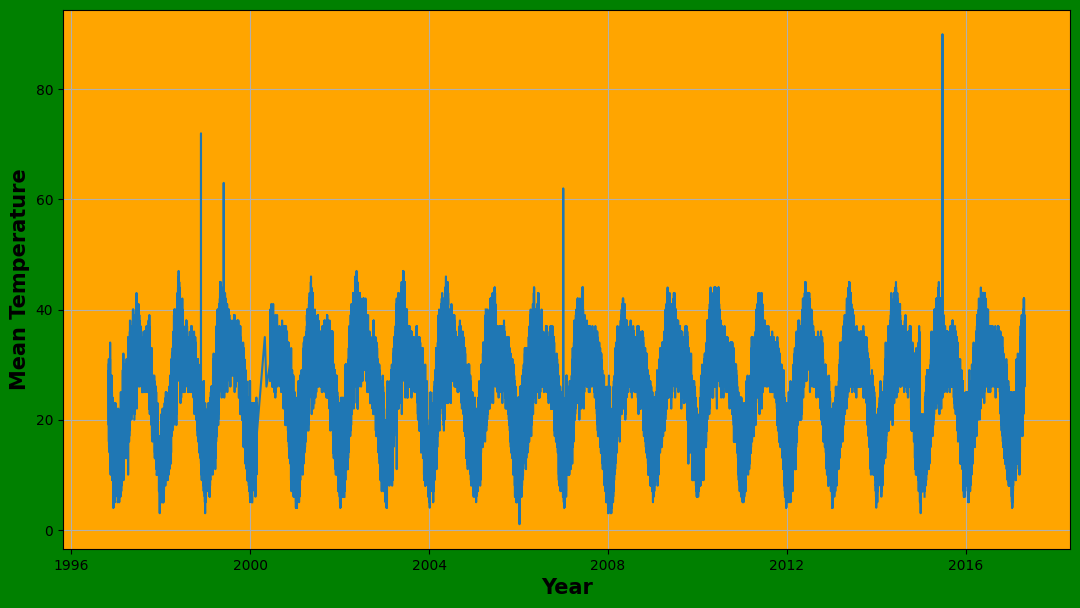

In [76]:
fig=plt.figure(figsize=(13,7),facecolor="green")
ax = plt.axes()
ax.set_facecolor("orange")
plt.xlabel("Year",fontsize="15",fontweight="bold")
plt.ylabel("Mean Temperature",fontsize="15",fontweight="bold")
plt.grid(True)
plt.plot(data)
plt.show()

**Counting null values: There are 673 null values in our data but as of now we will not handle the missing data, I have handled in later part of Notebook**

In [13]:
null=data[data.isnull().any(axis=1)]
print("Null values:",null.shape[0])

Null values: 673


**Obtain the average temperature of days in a month(daily_mean),monthly mean(monthly_mean) in a year and hourly mean in a day.**

In [14]:
daily_mean=data.groupby(data.index.day).mean()
monthly_mean=data.groupby(data.index.month).mean()
hourly_mean=data.groupby(data.index.hour).mean()
yearly_mean=data.groupby(data.index.year).mean()


**The plot below makes sense to us, the temperature rises during daytime and drops towards evening and morning.**

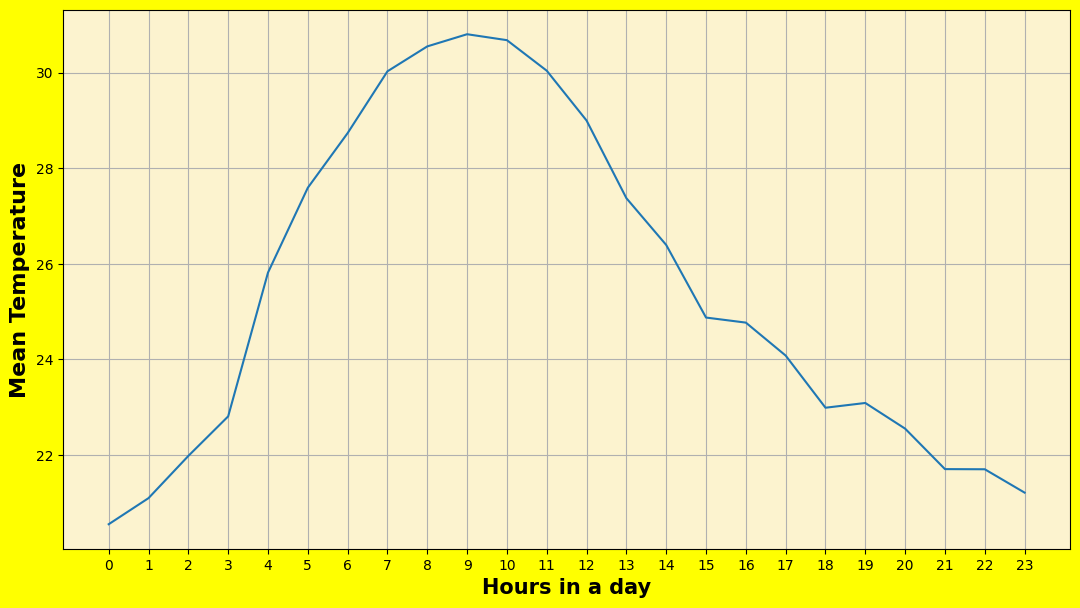

In [15]:
fig=plt.figure(figsize=(13,7),facecolor="yellow")
ax=plt.axes()
ax.set_facecolor("#FCF3CF")
plt.plot(hourly_mean)
plt.grid(True)
plt.xticks(range(0,24))
plt.xlabel("Hours in a day",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=16,fontweight="bold")
plt.show()

**The monthly_mean plot depicts that the avg temperature is highest during the summer season(March-July) and drops significantly in winter seasons.**

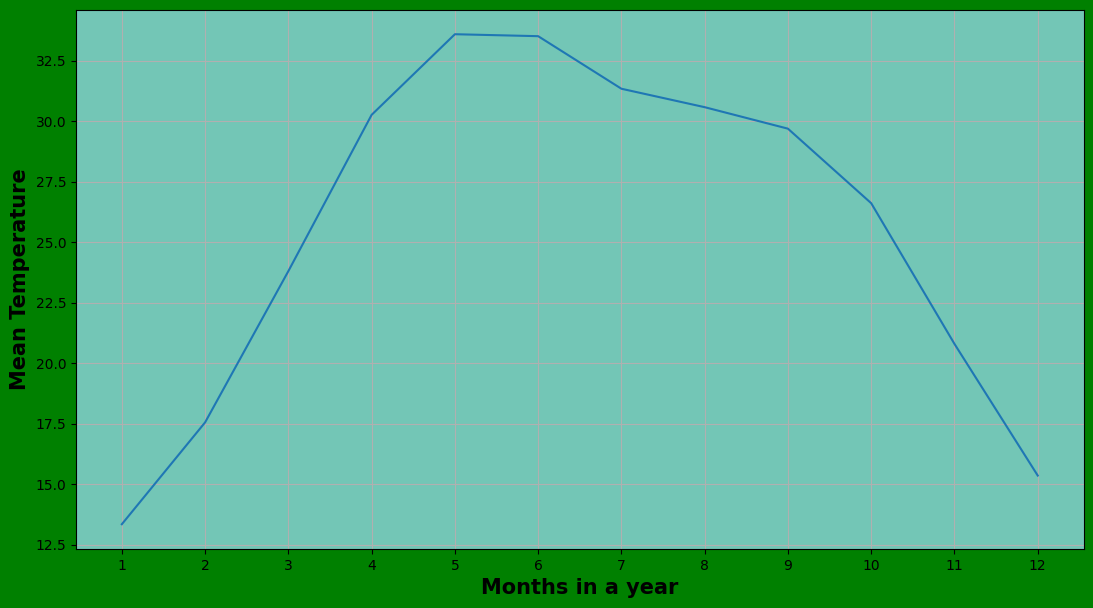

In [16]:
fig=plt.figure(figsize=(13,7),facecolor="green")
ax=plt.axes()
ax.set_facecolor("#73C6B6")
plt.plot(monthly_mean)
plt.grid(True)
plt.xticks(range(1,13))
plt.xlabel("Months in a year",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.show()

**There is no noticeable patterns in the days in month, because temperature varies in different days in different months.**

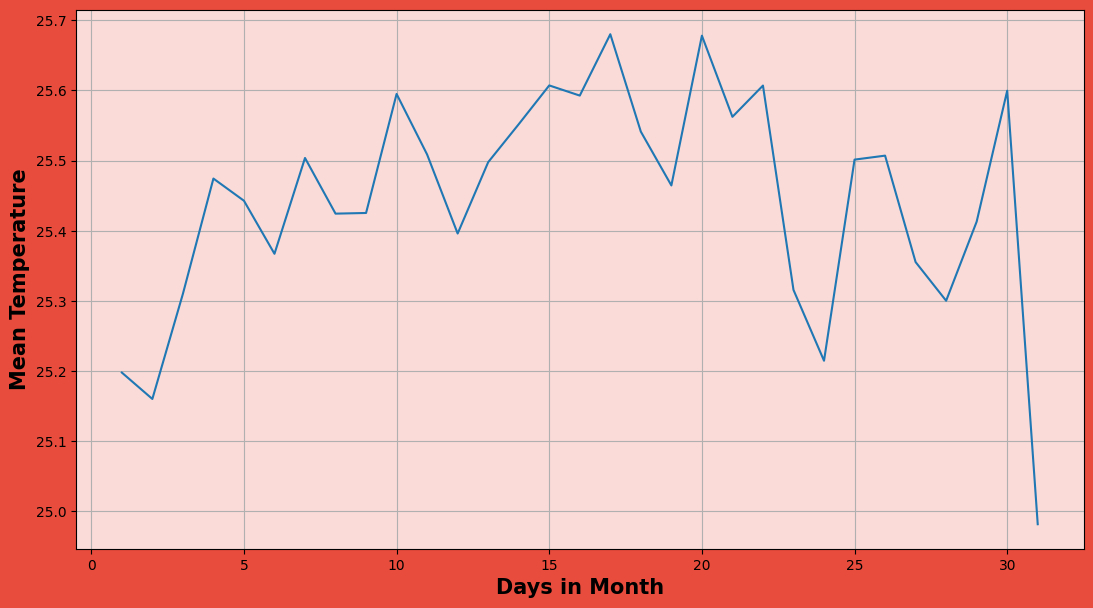

In [17]:
fig=plt.figure(figsize=(13,7),facecolor="#E74C3C")
ax=plt.axes()
ax.set_facecolor("#FADBD8")
plt.plot(daily_mean)
plt.grid(True)
plt.xlabel("Days in Month",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.show()

**Delhi have experienced a sharp increase in average yearly temperature in late 1990s and have stabalized after 2002.**

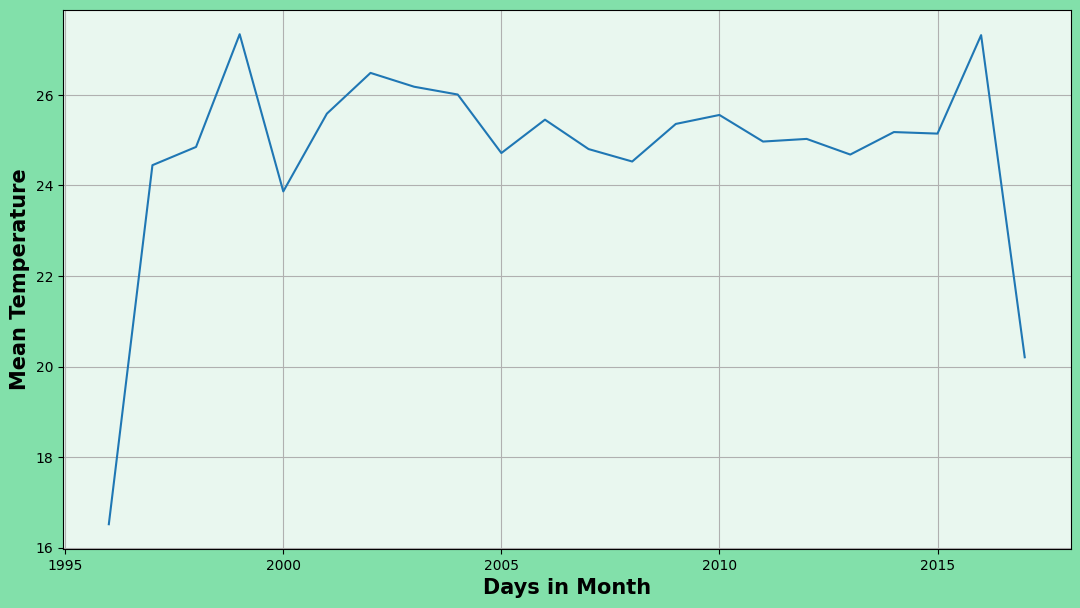

In [18]:
fig=plt.figure(figsize=(13,7),facecolor="#82E0AA")
ax=plt.axes()
ax.set_facecolor("#E9F7EF")
plt.plot(yearly_mean)
plt.grid(True)
plt.xlabel("Days in Month",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.show()

# Analysis of Daily Data

**We will now resample our hourly data into daily data using the resampling method**

In [19]:
daily=data.resample("D").mean()
print("Sample reduced by {} rows after resampling".format(data.shape[0]-daily.shape[0]))

Sample reduced by 93510 rows after resampling


**As we plot our daily data we now observe that in between 2000-2001 there are huge amount of missing data, so we will take the dataset from 2001 and drop the data of preceding days.**

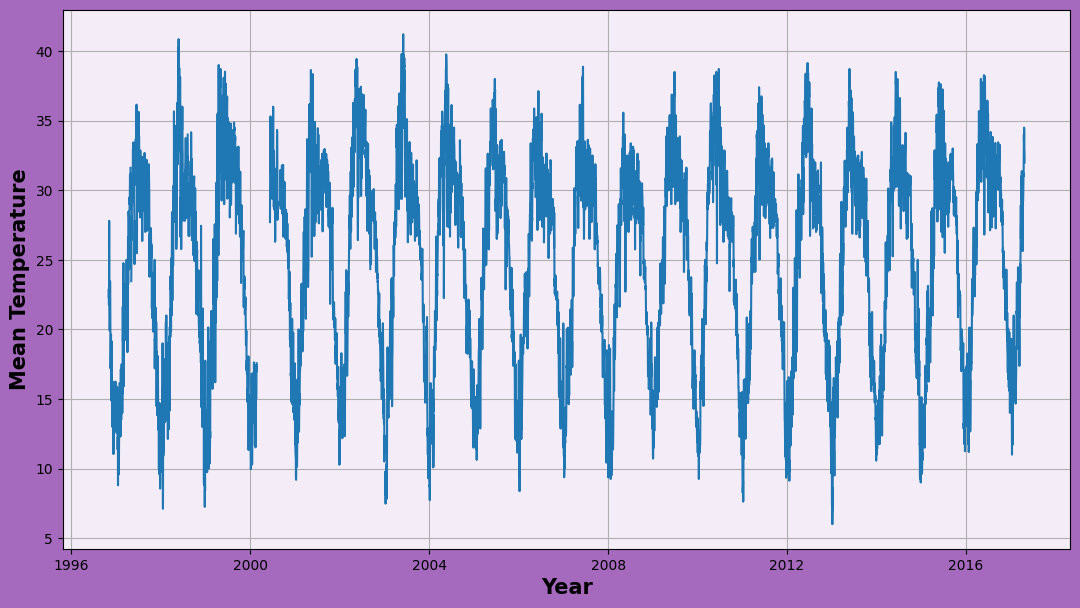

In [20]:
fig=plt.figure(figsize=(13,7),facecolor="#A569BD")
ax=plt.axes()
ax.set_facecolor("#F4ECF7")
plt.xlabel("Year",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.grid(True)
plt.plot(daily)
plt.show()

**Droping daily data before 2001-01-01**

In [21]:
daily=daily["2001-01-01":]
daily.shape

(5958, 1)

**Now my data contains observations from 2001-01-01 as seen in the plot below**

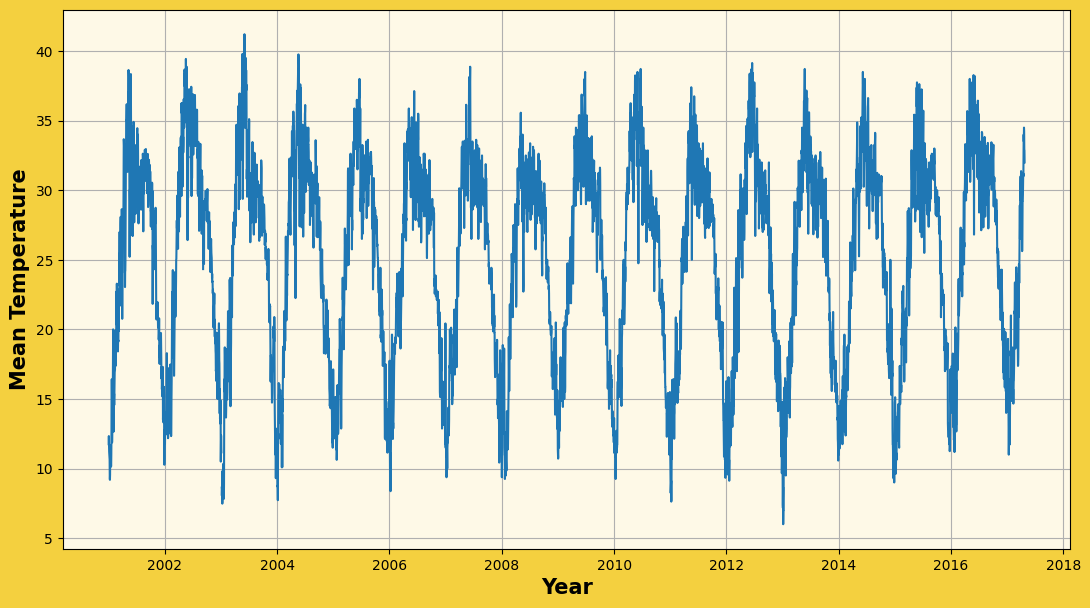

In [22]:
fig=plt.figure(figsize=(13,7),facecolor="#F4D03F")
ax=plt.axes()
ax.set_facecolor("#FEF9E7")
plt.xlabel("Year",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.grid(True)
plt.plot(daily)
plt.show()

**Despite removing huge chunk of missing data, I re-encountered 4 missing data, since now the amount of missing data is very small compared to the total datasize, I have filled the daily missing data using the temperatures of preceding days.**

In [23]:
print("Null values before:",daily.isnull().sum())

daily=daily.fillna(method="ffill")

print("Null values After:",daily.isnull().sum())

Null values before: temp    4
dtype: int64
Null values After: temp    0
dtype: int64


# MA(Moving Average to predict daily temperature):

**Since there is minute difference in the temperature between consecutive days, I assumed that present days temperature will be equivalent to the average temperature of its preceding day.**

**So I have used current temperature as the temperature of its past one day and for that reason I have made a predicted temperature by shifting the dataframe by one row.**

In [24]:
actual=daily["temp"].to_frame().rename(columns={"temp":"actual"})
predicted=daily["temp"].to_frame().shift(1).rename(columns={"temp":"predicted"})

df_daily=pd.concat([actual,predicted],axis=1)

In [25]:
df_daily.head()

,actual,predicted
date,,
2001-01-01,11.750000,NaN
2001-01-02,12.333333,11.750000
2001-01-03,11.666667,12.333333
2001-01-04,11.208333,11.666667
2001-01-05,11.000000,11.208333


**There is one nan row because of shifting so I have deleted that**

In [26]:
df_daily=df_daily[1:]

**The blue line shows actual data and orange as predicted temperature, we can see that the plot is so identical and the forecasting is so precise**

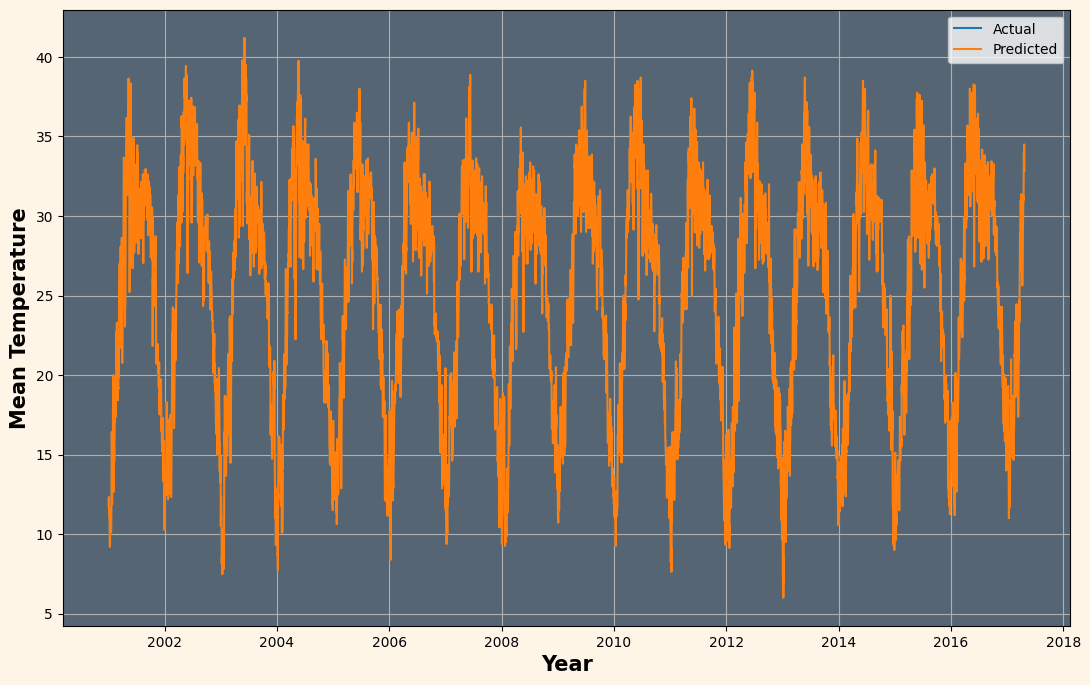

In [27]:
fig=plt.figure(figsize=(13,8),facecolor="#FEF5E7")
ax=plt.axes()
ax.set_facecolor("#566573")
plt.plot(df_daily["actual"],label="Actual")
plt.plot(df_daily["predicted"],label="Predicted")
plt.xlabel("Year",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.grid(True)
plt.legend(loc="best")
plt.show()

**RMSE values accounts to 1.6 which is pretty good.**

In [28]:
rmse=mean_squared_error(df_daily["actual"],df_daily["predicted"],squared=False)
print("RMSE: {:.1f}".format(rmse))

RMSE: 1.6


# Disadvantage of MA:

* **Since I am just taking the temperature of past as the temperature of future, in a long run my model will just be predicting same recorded temperatures, this is so Naive of MA model.**
* **We know that for past decades we are experiencing a rise in temperature(global warming), and it will increase in the future, so for that reason we also have to take into account of exogenous features/variables, which MA neglects.**


# Analysis of Monthly Data

**I have resampled my daily data into monthly data**

**As we can see the plot becomes more smoother than the daily data**

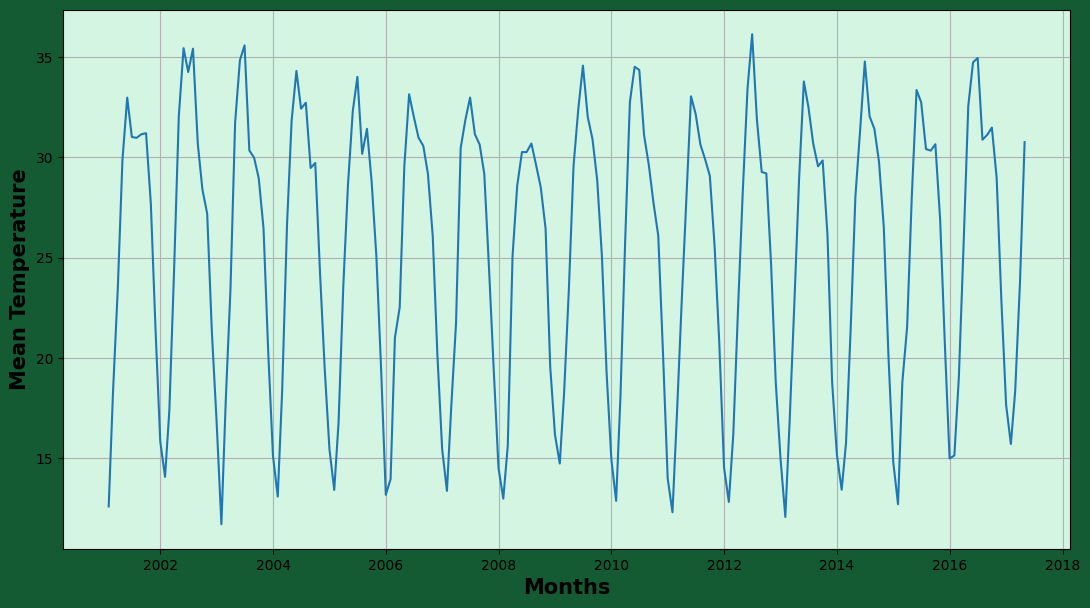

In [29]:
monthly=daily.resample("M").mean()
fig=plt.figure(figsize=(13,7),facecolor="#145A32")
ax=plt.axes()
ax.set_facecolor("#D5F5E3")
plt.plot(monthly)
plt.xlabel("Months",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.grid(True)
plt.show()

**Components of Time Series Data:**

**1. Trend: A gradual increase or decrease increase in the of observations(mean & variance) over a long period of time.**

**2. Seasonality: Repeating/predictable pattern over a certain time period.**

**3. Residual: It is also called as the white noise, which generally are the errors which does not account to trend and seasonality.**

**I have decomposed monthly data and it shows clear seasonality in every 12 months and from 2002-2008 the monthly temperature decreases, however increases later.**

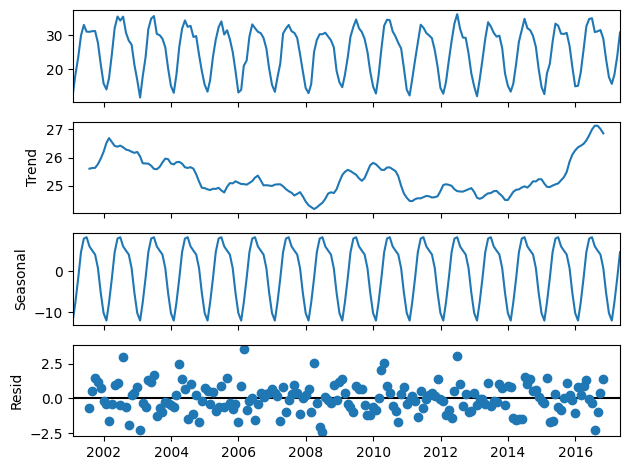

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(monthly)
result.plot()
plt.show()

In [31]:
monthly.head()

,temp
date,
2001-01-31,12.598292
2001-02-28,18.312059
2001-03-31,23.481593
2001-04-30,29.852883
2001-05-31,32.973339


# Stationarity test:

**Non-Stationarity data: Since we have observed that our data exhibits seasonality and trend & it will effect value of time series at different time. So to feed our time series data to Models we have to convert them into stationary data**

**Stationairty data: Data whose properties does not depend on time. The mean and variance remain constant with change in time, and hence the data dependence on time will be eliminated can perform statistical analysis on stationary data.**

# Ways to check stationarity:
**1. Visualization: We have concluded form the above visualization plots that the data exhibits seasonality.**

**2. Adfuller test: We can confirm data stationarity using adfuller statistics which I have discussed below**

In [32]:
from statsmodels.tsa.stattools import adfuller

**The function will return the adfuller statistics**


In [33]:
def check_adfuller(data):
    result=adfuller(data)
    
    print("ADF statistics:{}".format(result[0]))
    print("p-value:{}".format(result[1]))
    print("lags used:{}".format(result[2]))
    print("No of observation:{}".format(result[3]))
    print()
    print("Critical Values:")
    for key,value in result[4].items():
        print("Critical({}):{}".format(key,value))    

**Ideally we consider that time series data as stationary if p-value<0.05 & ADF statstics lesser than critical values, however in this case we have p=0.55 and ADF statistics greater than critical values, hence we conclude that our monthly data is not stationary.** 

In [34]:
check_adfuller(monthly)

ADF statistics:-1.4573021068379521
p-value:0.5545178229366753
lags used:11
No of observation:184

Critical Values:
Critical(1%):-3.466398230774071
Critical(5%):-2.8773796387256514
Critical(10%):-2.575213838610586


# How to make data stationary?
**Differencing**: It is a method of transforming a time series dataset. It can be used to remove the series dependence on time, so-called temporal dependence. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.


**For this reason I have used differencing with an order of 12(Seasonal order) as we have observed that data has a repeating pattern after 12 months period.**

In [35]:
monthly["Seasonal Diff"]=monthly["temp"]-monthly["temp"].shift(12)

**Now our p-value is less than 0.05 and ADF statistics smaller than critical values, now we have obtained a stationary data.**

In [36]:
check_adfuller(monthly["Seasonal Diff"].dropna())

ADF statistics:-4.34940419690806
p-value:0.00036439290613111936
lags used:12
No of observation:171

Critical Values:
Critical(1%):-3.4691814633722453
Critical(5%):-2.878595143532943
Critical(10%):-2.5758625549741803


**Comparing the Differenced series with an original series it have remove trend and sesonality form our data**

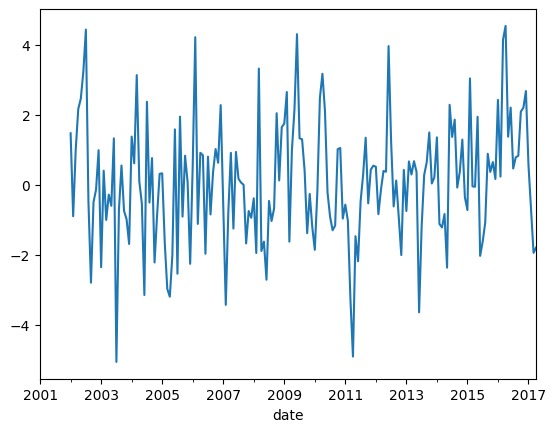

In [37]:
monthly["Seasonal Diff"].plot()
plt.show()

**Lets plot auto-correlation and partial auto-correlation for the differenced series**

**Auto-Correlation plot will help find MA order and partial-autocorrelation for AR order i.e the order of p,q for time series model**

In [38]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

**Both acf & pacf plot shows significant bar after every 12 lags, but it is very difficult to get the orders of MA and AR orders from the plots so I have used gridSearch to search over various combinations that yeilds the smallest AIC.**

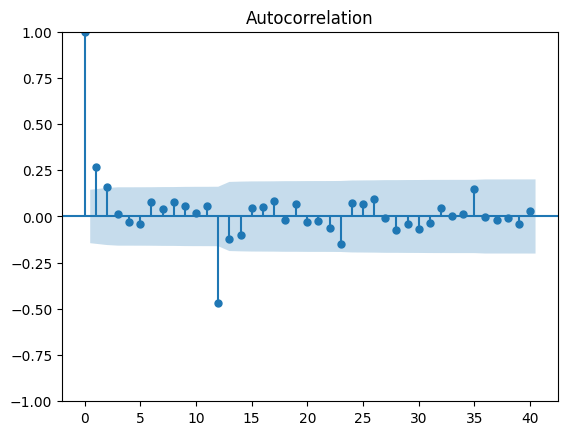

In [39]:
plot_acf(monthly["Seasonal Diff"].dropna(),lags=40)
plt.show()

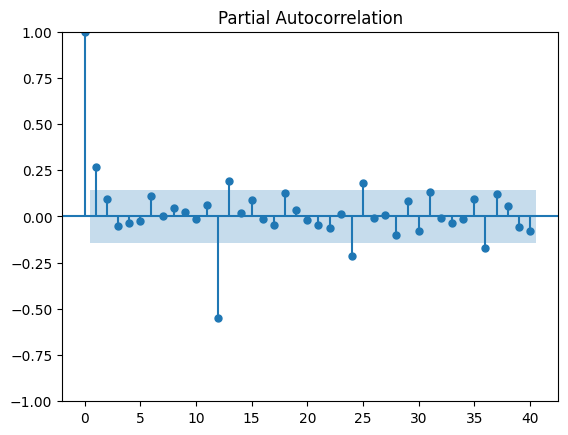

In [40]:
plot_pacf(monthly["Seasonal Diff"].dropna(),lags=40)
plt.show()

# Data Splitting

**I used temperature data from 2002-2015 to train the model and 2015-2017 for testing purpose**

In [41]:
train=monthly["temp"][:"2015-01-01"].to_frame()
test=monthly["temp"]["2015-01-01":].to_frame()

train.shape,test.shape

((168, 1), (28, 1))

# SARIMAX

**There are few other models for TimeSeries data but for this data I have used SARIMAX model**

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

**SARIMAX takes arguments order=(p,d,q) & seasonal_order=(P,D,Q,s), so for this reason I have initialized parameters to grid search over the best parameters for SARIMAX.**

In [43]:
p=d=q=range(0,2)

pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

**This for loop will iterate over all combinations of initialized parameters, fit SARIMAX model with all combinations and parameters yeilding lowest AIC will be selected**

In [44]:
for pdq_params in pdq:
    for seasonal_params in seasonal_pdq:
        try:
            model=SARIMAX(train,
                          order=pdq_params,
                          seasonal_order=seasonal_params
                         )
            result=model.fit()
            print("SARIMAX({}x{}12)-AIC:{}".format(pdq_params,
                                                   seasonal_params,
                                                   result.aic
                                                  ))
            
        except:
            continue

SARIMAX((0, 0, 0)x(0, 0, 0, 12)12)-AIC:1575.3656636797043
SARIMAX((0, 0, 0)x(0, 0, 1, 12)12)-AIC:1390.5375258850618
SARIMAX((0, 0, 0)x(0, 1, 0, 12)12)-AIC:610.9787293772407
SARIMAX((0, 0, 0)x(0, 1, 1, 12)12)-AIC:540.178869124471
SARIMAX((0, 0, 0)x(1, 0, 0, 12)12)-AIC:725.2412722230706
SARIMAX((0, 0, 0)x(1, 0, 1, 12)12)-AIC:655.9117330359722
SARIMAX((0, 0, 0)x(1, 1, 0, 12)12)-AIC:563.3856950592533
SARIMAX((0, 0, 0)x(1, 1, 1, 12)12)-AIC:541.7859173710231
SARIMAX((0, 0, 1)x(0, 0, 0, 12)12)-AIC:1364.0946495479732
SARIMAX((0, 0, 1)x(0, 0, 1, 12)12)-AIC:1207.716538181368
SARIMAX((0, 0, 1)x(0, 1, 0, 12)12)-AIC:606.6210148866423
SARIMAX((0, 0, 1)x(0, 1, 1, 12)12)-AIC:526.6382578352777
SARIMAX((0, 0, 1)x(1, 0, 0, 12)12)-AIC:716.3946043262024
SARIMAX((0, 0, 1)x(1, 0, 1, 12)12)-AIC:635.1952853975765
SARIMAX((0, 0, 1)x(1, 1, 0, 12)12)-AIC:553.7546593787099
SARIMAX((0, 0, 1)x(1, 1, 1, 12)12)-AIC:527.0513181135366
SARIMAX((0, 1, 0)x(0, 0, 0, 12)12)-AIC:952.5233359178744
SARIMAX((0, 1, 0)x(0, 0, 1, 1

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX((1, 1, 1)x(1, 0, 1, 12)12)-AIC:597.9033085342217
SARIMAX((1, 1, 1)x(1, 1, 0, 12)12)-AIC:555.7809487122033
SARIMAX((1, 1, 1)x(1, 1, 1, 12)12)-AIC:524.6418270268379


We have observed the model with **SARIMAX((1, 0, 0)x(0, 1, 1, 12)12)-AIC:522.8763887409265** is better than all other combinations hence we will use this combination as our parameters


In [45]:
model=SARIMAX(train,
              order=(1,0,0),
              seasonal_order=(0,1,1,12)
             ).fit()

**Model Summary**

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  168
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -258.438
Date:                              Sat, 11 Jan 2025   AIC                            522.876
Time:                                      16:33:10   BIC                            532.026
Sample:                                  01-31-2001   HQIC                           526.593
                                       - 12-31-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3473      0.065      5.308      0.000       0.219       0.476
ma.S.L12      -0.9045      0.145     -6.253      0.000      -1.188      -0.621
sigma2         1.4166      0.211      6.728      0.000       1.004       1.829
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.51   Prob(JB):                         0.60
Heteroskedasticity (H):               0.52   Skew:                             0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Residual plot: There is no obvious patterns observed.**

**Histogram + KDE plot: KDE curve is similar to the normal distribution**

**Normal Q-Q: Most of the data points lies on the red line**

**Correlogram :correlations for lag greater than one is not significant** 

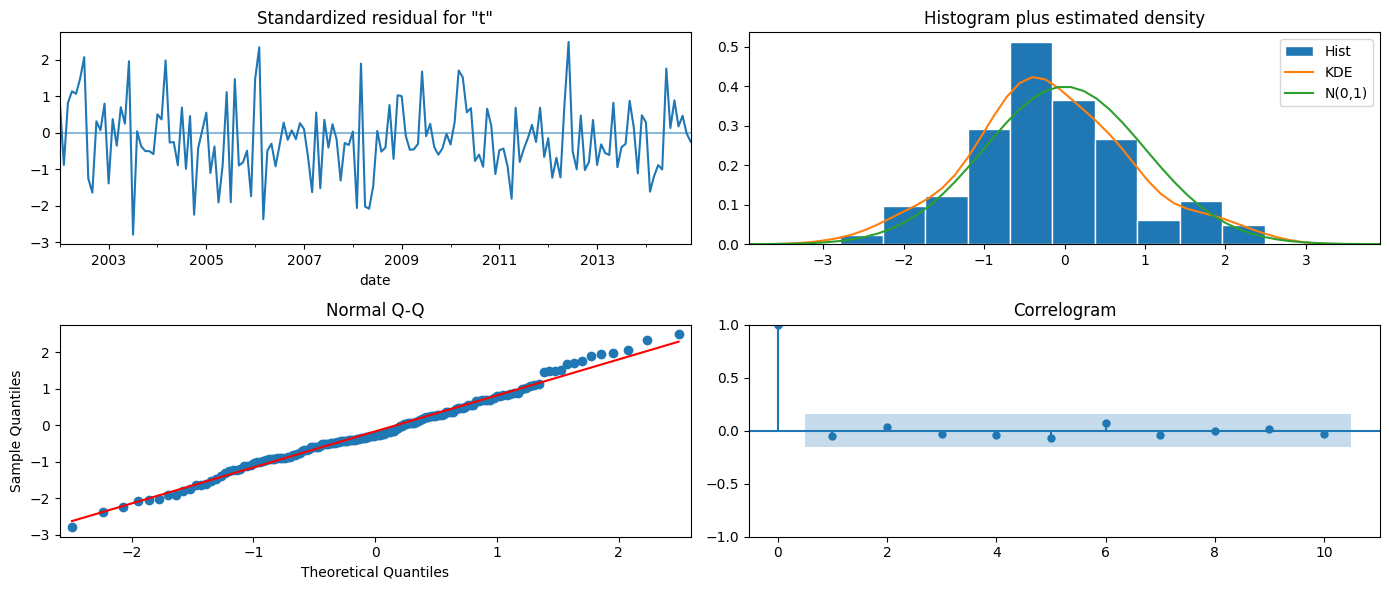

In [47]:
model.plot_diagnostics(figsize=(14,6))
plt.tight_layout()
plt.show()

**Predict the test data**

In [48]:
predict=model.get_prediction(start=len(train),
                             end=(len(train)+len(test)-1)
                            )

**get the upper and lower bounds of predicted values**

In [49]:
predict_values=predict.predicted_mean
bounds=predict.conf_int()
bounds.head()

,lower temp,upper temp
2015-01-31,10.655942,15.349419
2015-02-28,14.835497,19.803279
2015-03-31,20.908592,25.908448
2015-04-30,27.132449,32.136160
2015-05-31,30.525536,35.529711


In [50]:
lower_lim=bounds["lower temp"]
upper_lim=bounds["upper temp"]

**Our Prediction is working well as of now and giving us good results on Test data**

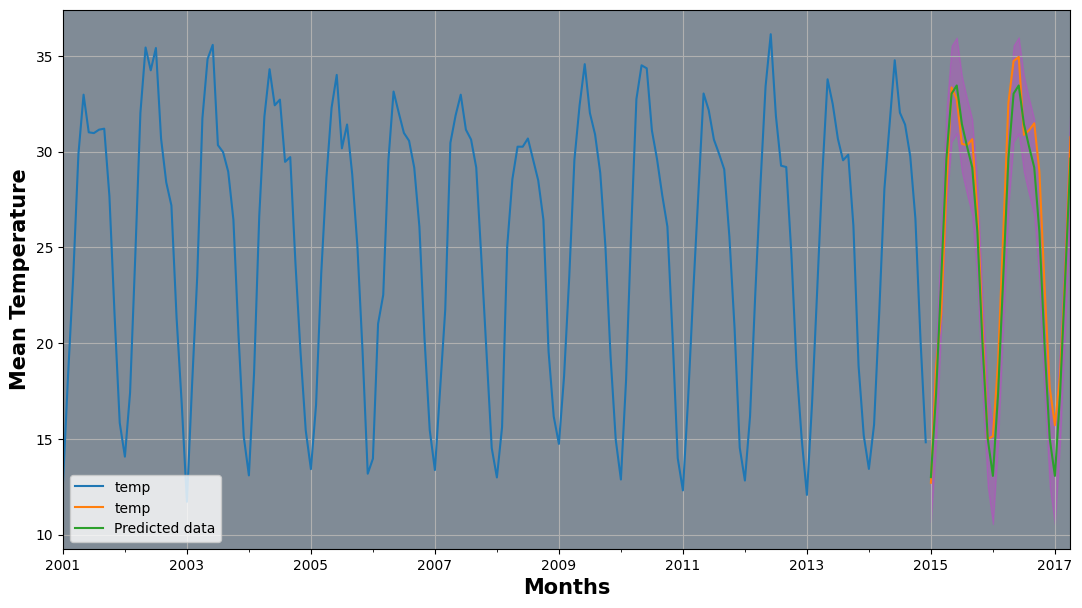

In [51]:
ax=train.plot(label="Training Data",figsize=(13,7))
test.plot(label="Testing Data",ax=ax)
predict_values.plot(label="Predicted data",ax=ax)
ax.fill_between(bounds.index,lower_lim,upper_lim,color="magenta",alpha=0.2)
ax.set_facecolor("#808B96")
plt.xlabel("Months",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.grid(True)
plt.legend(loc="best")
plt.show()

**RMSE is 1.7 which is pretty good**

In [52]:
rmse=mean_squared_error(test["temp"].values,predict_values,squared=False)
rmse

1.71553301440337

In [53]:
test.tail()

,temp
date,
2016-12-31,17.672565
2017-01-31,15.710873
2017-02-28,18.349981
2017-03-31,23.753760
2017-04-30,30.753663


**Now lets try to predict new data from March 2017 to December 2021**

In [54]:
dates_to_predict=pd.date_range(start="2017-04-30",end="2021-12-31",freq="M")
len(dates_to_predict)

57

In [55]:
new_predict=model.get_prediction(start=len(monthly),
                                 end=(len(monthly)+len(dates_to_predict)-1)
                                )

In [56]:
new_predict_values=new_predict.predicted_mean

In [57]:
new_bounds=new_predict.conf_int()
new_lower_lim=new_bounds["lower temp"]
new_upper_lim=new_bounds["upper temp"]

**The new predicted Monthly average Temperature**

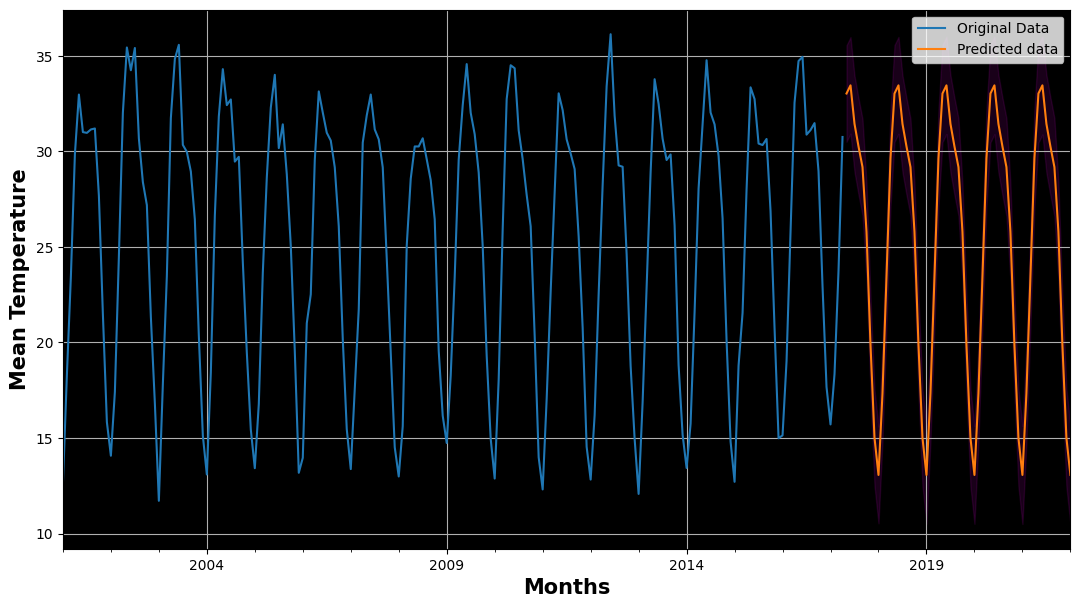

In [58]:
ax=monthly["temp"].plot(label="Original Data",figsize=(13,7))
new_predict_values.plot(label="Predicted data",ax=ax)
ax.fill_between(new_bounds.index,new_lower_lim,new_upper_lim,color="magenta",alpha=0.1)

ax.set_facecolor("black")
plt.xlabel("Months",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.grid(True)
plt.legend(loc="best")
plt.show()

# Neural Networks(LSTM)

**I will now build a neural network, that will help us forecast the same temperature data**

**We have our train and test data ready, but to feed data into neural network it is  highly recommended to transform data, for this purpose I have Normalized the data between 0-1, using MinMaxScaler**

In [59]:
from sklearn.preprocessing import MinMaxScaler

**tranform the temperatures in bw 0-1**

In [60]:
scaler=MinMaxScaler()
train_scale=scaler.fit_transform(train)
test_scale=scaler.transform(test)

# Data Prepreparation:

**Once the data is scaled we will prepare data in such a way that using past 12 months it will help predict avg temperature the comming month.**

**keras TimeseriesGenerator helps builds the sequence without us having have to prepare data manually**

In [61]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

**Explanation:**

TimeseriesGenerator takes arguments 

**data**(data from where we generate sequence),

**targets**(data from where we generate targets),

**length**(time steps to consider for building sequnce)



In [62]:
time_step=12
generator=TimeseriesGenerator(data=train_scale,
                              targets=train_scale,
                              length=time_step,
                              batch_size=1
                             )

**Now data is ready and its time to build Neural Networks to feed in training data**

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam

**Initialize sequentail model**

In [94]:
model=Sequential()

**Model Building and Model Compiling**

In [95]:
model.add(LSTM(100,activation="tanh",input_shape=(time_step,1),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64,activation="tanh"))
model.add(Dropout(0.01))

model.add(Dense(32))

model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="mean_squared_error",
              metrics=["mse"]
             )

In [96]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 12, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,153 (332.63 KB)

 Trainable params: 85,153 (332.63 KB)

 Non-trainable params: 0 (0.00 B)

**Set a call back for my model with patience=50**

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

callback=EarlyStopping(monitor="loss",patience=50)

**fit model with training data**

In [98]:
model.fit(generator,epochs=200,steps_per_epoch=3,verbose=False,callbacks=[callback])

**Visualizing loss per epoch, the loss is varying overtime but decreases significantly with increase in epoch**

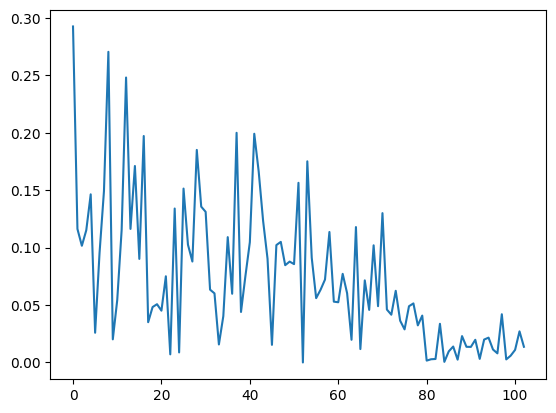

In [99]:
loss_per_epoch=model.history.history["loss"]
plt.plot(loss_per_epoch)
plt.show()

# Get the test prediction

**Explanation**:

As I have mentioned earlier we use past 12 months to get the temperature of present month, so to predict the temperature of first test month I have to use the last 12 months of traning data.

Since LSTM layer accpets 3-dim data i have reshaped the input data.

Once we get the prediction of first test month, I will append the predicted temperature with the 11 other temperatures(By removing the first month) of current_batch, & repeat this process will repeat until the length of test data.

In [100]:
test_pred=[]

test_batch=train_scale[-time_step:]
current_batch=test_batch.reshape(1,time_step,1)

for i in range(len(test)):
    pred=model.predict(current_batch)[0]
    test_pred.append(pred)
    
    current_batch=np.append(current_batch[:,1:,:],[[pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [101]:
test_pred

[array([0.16486464], dtype=float32),
 array([0.24583787], dtype=float32),
 array([0.42796487], dtype=float32),
 array([0.63192755], dtype=float32),
 array([0.78986174], dtype=float32),
 array([0.88036954], dtype=float32),
 array([0.87387425], dtype=float32),
 array([0.8134312], dtype=float32),
 array([0.68728405], dtype=float32),
 array([0.5189984], dtype=float32),
 array([0.34595272], dtype=float32),
 array([0.22880048], dtype=float32),
 array([0.21209052], dtype=float32),
 array([0.2903265], dtype=float32),
 array([0.4512634], dtype=float32),
 array([0.6334926], dtype=float32),
 array([0.7794887], dtype=float32),
 array([0.85602134], dtype=float32),
 array([0.85115904], dtype=float32),
 array([0.7766229], dtype=float32),
 array([0.649113], dtype=float32),
 array([0.49765894], dtype=float32),
 array([0.3560544], dtype=float32),
 array([0.26222578], dtype=float32),
 array([0.24937922], dtype=float32),
 array([0.3288338], dtype=float32),
 array([0.47751364], dtype=float32),
 array([0.64

**We have Normalized our data in range 0-1, so get the temperatures we will inverse transform the scaled data into its original scale**

In [102]:
true_pred=scaler.inverse_transform(test_pred)

In [103]:
test["pred"]=true_pred

**We obtain a rmse of 3.69 which is higher that of SARIMAX model, however Neural Networks always provides room for model improvement,thus by using valid activation function and neurons this can be improved**

In [104]:
rmse=mean_squared_error(test["temp"],true_pred,squared=False)
rmse

2.485406017721005

**Plot showing traning testing and predicted temperature using LSTM**

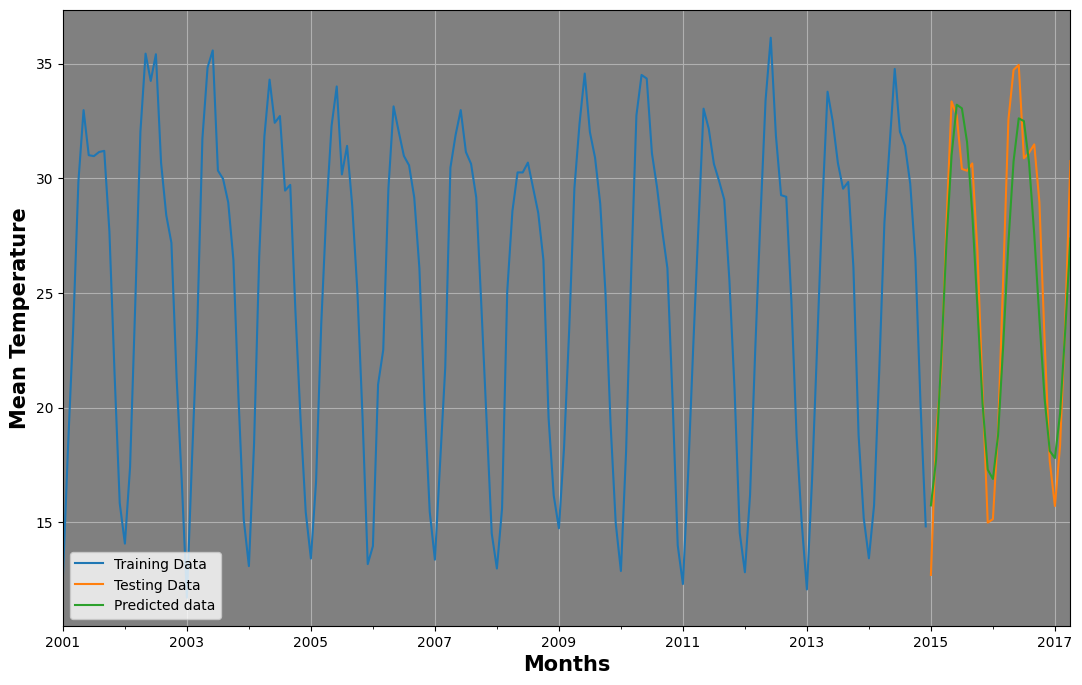

In [105]:
ax=train["temp"].plot(label="Training Data",figsize=(13,8))
ax.set_facecolor("gray")
test["temp"].plot(label="Testing Data")
test["pred"].plot(label="Predicted data",ax=ax)
plt.grid(True)
plt.xlabel("Months",fontsize=15,fontweight="bold")
plt.ylabel("Mean Temperature",fontsize=15,fontweight="bold")
plt.legend(loc="best")
plt.show()